# AI CFO - RAG Evaluation Harness

This notebook runs a comprehensive suite of tests against the AI CFO's RAG pipeline using a golden dataset.
It evaluates key reliability metrics:

1. **Context Precision**: Did we retrieve relevant information?
2. **Faithfulness (Groundedness)**: Did the answer stick to the facts from the retrieved context?
3. **Answer Correctness**: Was the final answer correct compared to our ground truth?
4. **Number Accuracy**: Were the numerical values in the answer correct?

## Architecture Overview

- **Golden Dataset**: `golden_dataset.json` contains test cases with questions, ideal answers, and ground truth context
- **System Under Test**: The `run_react_rag` function from the main application
- **Evaluation**: LLM-as-a-Judge for qualitative metrics, regex-based for numerical accuracy
- **Output**: CSV results file with detailed metrics and analysis

## Section 1: Environment Setup and Dependencies

Import required libraries and configure the project environment for accessing the AI CFO source code.

In [1]:
import asyncio
import json
import os
import re
import sys
from typing import Dict, Any, List

import pandas as pd
from litellm import completion
from supabase import create_client, Client

# Add project root to sys.path to allow imports from src/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")
print(f"Current working directory: {os.getcwd()}")
print(f"Python path includes: {project_root in sys.path}")

# Local imports from evaluation module
from evaluation.config import (
    GOLDEN_DATASET_PATH, EVAL_RESULTS_PATH, JUDGE_MODEL,
    CONTEXT_PRECISION_PROMPT, FAITHFULNESS_PROMPT, ANSWER_CORRECTNESS_PROMPT,
    TEST_USER_EMAIL, TEST_USER_PASSWORD, SUPABASE_URL, SUPABASE_KEY
)

print("\n=== Configuration Loaded ===")
print(f"Golden Dataset Path: {GOLDEN_DATASET_PATH}")
print(f"Results Output Path: {EVAL_RESULTS_PATH}")
print(f"Judge Model: {JUDGE_MODEL}")
print(f"Test User Email: {TEST_USER_EMAIL}")
print(f"Supabase URL: {SUPABASE_URL[:20]}..." if SUPABASE_URL else "Not configured")

Project root: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP
Current working directory: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\evaluation
Python path includes: True

=== Configuration Loaded ===
Golden Dataset Path: golden_dataset.json
Results Output Path: eval_results.csv
Judge Model: gemini/gemini-2.5-flash-lite
Test User Email: user@example.com
Supabase URL: https://orkvwbdwatlg...


## Section 2: Golden Dataset Creation

Load and validate the golden dataset JSON file containing test cases with questions, ideal answers, ground truth context, and evaluation tags.

In [2]:
# Reload configuration to get correct paths
import importlib
import evaluation.config
importlib.reload(evaluation.config)

from evaluation.config import GOLDEN_DATASET_PATH, EVAL_RESULTS_PATH

def load_golden_dataset(dataset_path: str) -> List[Dict[str, Any]]:
    """Load and validate the golden dataset."""
    print(f"Looking for dataset at: {os.path.abspath(dataset_path)}")
    
    try:
        with open(dataset_path, 'r', encoding='utf-8') as f:
            dataset = json.load(f)
        
        # Validate dataset structure
        required_fields = ['test_id', 'question', 'ideal_answer', 'ground_truth_context', 'tags']
        
        for i, item in enumerate(dataset):
            missing_fields = [field for field in required_fields if field not in item]
            if missing_fields:
                raise ValueError(f"Test case {i} missing required fields: {missing_fields}")
        
        print(f"✅ Successfully loaded {len(dataset)} test cases")
        return dataset
        
    except FileNotFoundError:
        raise FileNotFoundError(f"Golden dataset not found at: {dataset_path}")
    except json.JSONDecodeError as e:
        raise ValueError(f"Invalid JSON in golden dataset: {e}")

# Load the golden dataset
print(f"Updated paths - Golden Dataset: {GOLDEN_DATASET_PATH}")
print(f"Updated paths - Results: {EVAL_RESULTS_PATH}")
golden_dataset = load_golden_dataset(GOLDEN_DATASET_PATH)

# Display dataset overview
print("\n=== Dataset Overview ===")
df_preview = pd.DataFrame(golden_dataset)
print(f"Total test cases: {len(golden_dataset)}")
print(f"Test IDs: {[item['test_id'] for item in golden_dataset]}")

# Show tag distribution
all_tags = [tag for item in golden_dataset for tag in item['tags']]
tag_counts = pd.Series(all_tags).value_counts()
print(f"\nTag distribution:")
print(tag_counts)

# Display first test case as example
print(f"\n=== Sample Test Case ===")
sample = golden_dataset[0]
print(f"ID: {sample['test_id']}")
print(f"Question: {sample['question']}")
print(f"Ideal Answer: {sample['ideal_answer'][:100]}...")
print(f"Tags: {sample['tags']}")

Updated paths - Golden Dataset: golden_dataset.json
Updated paths - Results: eval_results.csv
Looking for dataset at: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\evaluation\golden_dataset.json
✅ Successfully loaded 11 test cases

=== Dataset Overview ===
Total test cases: 11
Test IDs: ['FACT_RETRIEVAL_001', 'NUMBER_SCALE_001', 'MULTI_DOC_001', 'CALCULATION_001', 'AGGREGATION_001', 'NO_ANSWER_001', 'CHART_GEN_001', 'NEGATIVE_HANDLING_001', 'QUARTERLY_CALC_001', 'EXPENSE_BREAKDOWN_001', 'EXPENSE_BREAKDOWN_001']

Tag distribution:
accuracy          9
single-doc        6
multi-doc         3
negative-value    2
calculation       2
expenses          2
aggregation       2
scaling           1
comparison        1
no-answer         1
robustness        1
charting          1
tool-use          1
Name: count, dtype: int64

=== Sample Test Case ===
ID: FACT_RETRIEVAL_001
Question: What was the net income for Stellar Goods Inc. in May 2023?
Ideal Answer: The net income for Stellar Goods Inc. i

## Section 3: Authentication and Client Configuration

Create authenticated Supabase session using test credentials and configure the client with proper authorization headers for database access.

In [3]:
# Import required authentication components
from api.v1.dependencies import Session

async def get_test_session() -> Session:
    """
    Creates an authenticated session for the test user.
    This session will be used for all RAG system calls during evaluation.
    """
    if not all([TEST_USER_EMAIL, TEST_USER_PASSWORD, SUPABASE_URL, SUPABASE_KEY]):
        raise ValueError("Missing required environment variables for authentication")
    
    print(f"Authenticating user: {TEST_USER_EMAIL}")
    
    auth_client: Client = create_client(SUPABASE_URL, SUPABASE_KEY)
    
    try:
        response = await asyncio.to_thread(
            auth_client.auth.sign_in_with_password,
            {"email": TEST_USER_EMAIL, "password": TEST_USER_PASSWORD}
        )
        
        if not response.session:
            raise Exception("Authentication failed - no session returned")
        
        if not response.user:
            raise Exception("Authentication failed - no user returned")
        
        session = Session(
            user_id=response.user.id, 
            token=response.session.access_token
        )
        
        print(f"✅ Authentication successful")
        print(f"User ID: {session.user_id}")
        print(f"Token: {session.token[:20]}...")
        
        return session
        
    except Exception as e:
        print(f"❌ Authentication failed: {e}")
        raise Exception(f"Failed to create test session: {e}")

def create_authenticated_client(session: Session) -> Client:
    """
    Create a Supabase client with authentication headers set.
    """
    client = create_client(SUPABASE_URL, SUPABASE_KEY)
    client.options.headers["Authorization"] = f"Bearer {session.token}"
    return client

# Test authentication
print("=== Testing Authentication ===")
test_session = await get_test_session()
test_supabase_client = create_authenticated_client(test_session)

print(f"Session created for user: {test_session.user_id}")
print(f"Client configured with authentication headers")

=== Testing Authentication ===
Authenticating user: user@example.com
✅ Authentication successful
User ID: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Token: eyJhbGciOiJIUzI1NiIs...
✅ Authentication successful
User ID: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Token: eyJhbGciOiJIUzI1NiIs...
Session created for user: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Client configured with authentication headers
Session created for user: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Client configured with authentication headers


## Section 4: System Under Test (SUT) Wrapper Implementation

Build a wrapper function around the `run_react_rag` async generator to capture both the final answer and retrieved context for evaluation purposes.

**Note**: The current implementation uses a placeholder for retrieved context since capturing the actual context requires deeper instrumentation of the agent's tool calls.

In [5]:
# Import the main RAG function
from src.llm.workflow.react_rag import run_react_rag
from src.llm.tools.FunctionCaller import RetrievalService
from src.llm.OpenAIClient import OpenAIClient
from src.storage.SupabaseService import SupabaseService

class InstrumentedRetrievalService(RetrievalService):
    """
    A wrapper around RetrievalService that captures the retrieved context
    for evaluation purposes.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_retrieved_context = ""
        
    def retrieve_chunks(self, query: str, num_chunks: int = 10) -> str:
        """Override to capture the retrieved context - NOTE: This is NOT async."""
        result = super().retrieve_chunks(query, num_chunks)
        self.last_retrieved_context = result
        return result
    
    def get_last_context(self) -> str:
        """Get the last retrieved context for evaluation."""
        return self.last_retrieved_context

async def get_rag_response_with_context(question: str, session: Session, supabase_client: Client) -> Dict[str, Any]:
    """
    Enhanced wrapper that captures the actual retrieved context.
    This version instruments the RetrievalService to capture context.
    """
    print(f"  🔍 Processing question: {question[:50]}...")
    
    try:
        # Set up instrumented components
        instrumented_retrieval = InstrumentedRetrievalService(
            openai_client=OpenAIClient(),
            supabase_service=SupabaseService(supabase_client=supabase_client),
            user_id=session.user_id
        )
        
        # Patch the original retrieval service in the RAG function
        import src.llm.workflow.react_rag as rag_module
        original_retrieval_class = rag_module.RetrievalService
        rag_module.RetrievalService = lambda *args, **kwargs: instrumented_retrieval
        
        try:
            final_answer = ""
            chunk_count = 0
            
            # Consume the async generator to get the complete response
            async for chunk in run_react_rag(session, supabase_client, question, []):
                final_answer += chunk
                chunk_count += 1
                
                # Print progress for long responses
                if chunk_count % 10 == 0:
                    print(f"    📝 Received {chunk_count} chunks...")
            
            # Get the captured context
            retrieved_context = instrumented_retrieval.get_last_context()
            
            print(f"  ✅ Response complete: {len(final_answer)} characters, {chunk_count} chunks")
            print(f"  📄 Context captured: {len(retrieved_context)} characters")
            
            return {
                "final_answer": final_answer.strip(),
                "retrieved_context": retrieved_context,
                "chunk_count": chunk_count,
                "response_length": len(final_answer)
            }
            
        finally:
            # Restore original class
            rag_module.RetrievalService = original_retrieval_class
            
    except Exception as e:
        print(f"  ❌ Error in RAG response: {e}")
        import traceback
        traceback.print_exc()
        return {
            "final_answer": f"ERROR: {str(e)}",
            "retrieved_context": "ERROR: Could not retrieve context due to exception",
            "chunk_count": 0,
            "response_length": 0
        }

async def get_rag_response(question: str, session: Session, supabase_client: Client) -> Dict[str, Any]:
    """
    Wraps the run_react_rag function to make it a single-shot testable unit.
    It consumes the async generator and returns the final answer and context.
    
    Args:
        question: The user's question
        session: Authenticated session
        supabase_client: Configured Supabase client
    
    Returns:
        Dict containing 'final_answer' and 'retrieved_context'
    
    NOTE: This version attempts to capture real context, but falls back to basic version.
    """
    try:
        return await get_rag_response_with_context(question, session, supabase_client)
    except Exception as e:
        print(f"  ⚠️ Context capture failed, falling back to basic method: {e}")
        
        # Fallback to original method
        print(f"  🔍 Processing question: {question[:50]}...")
        
        try:
            final_answer = ""
            chunk_count = 0
            
            # Consume the async generator to get the complete response
            async for chunk in run_react_rag(session, supabase_client, question, []):
                final_answer += chunk
                chunk_count += 1
                
                # Print progress for long responses
                if chunk_count % 10 == 0:
                    print(f"    📝 Received {chunk_count} chunks...")
            
            print(f"  ✅ Response complete: {len(final_answer)} characters, {chunk_count} chunks")
            
            # Try to extract context from the response itself
            retrieved_context = extract_context_from_response(final_answer)
            
            return {
                "final_answer": final_answer.strip(),
                "retrieved_context": retrieved_context,
                "chunk_count": chunk_count,
                "response_length": len(final_answer)
            }
            
        except Exception as e2:
            print(f"  ❌ Error in RAG response: {e2}")
            return {
                "final_answer": f"ERROR: {str(e2)}",
                "retrieved_context": "ERROR: Could not retrieve context due to exception",
                "chunk_count": 0,
                "response_length": 0
            }

def extract_context_from_response(response: str) -> str:
    """
    Try to extract context from the response by looking for source citations
    and financial data patterns.
    """
    if "Sources:" in response:
        # Extract everything after Sources:
        sources_section = response.split("Sources:")[-1].strip()
        return f"Extracted from response sources: {sources_section[:200]}..."
    elif any(keyword in response.lower() for keyword in ['revenue', 'income', 'profit', 'expense']):
        # If it contains financial terms, assume it found relevant context
        return "Financial data found in response (context extraction from response text)"
    else:
        return "No clear context indicators found in response"

# Test the enhanced SUT wrapper with a simple question
print("=== Testing Enhanced SUT Wrapper ===")
test_question = "What was the revenue for October 2023?"
test_response = await get_rag_response(test_question, test_session, test_supabase_client)

print(f"\nTest Response:")
print(f"Answer length: {len(test_response['final_answer'])} characters")
print(f"Answer preview: {test_response['final_answer'][:200]}...")
print(f"Context type: {type(test_response['retrieved_context'])}")
print(f"Context preview: {test_response['retrieved_context'][:200]}...")

=== Testing Enhanced SUT Wrapper ===
  🔍 Processing question: What was the revenue for October 2023?...
Initialized OpenAI client with model: text-embedding-3-small
SupabaseService initialized with provided client.
[DEBUG] run_react_rag called with session.user_id=372ec112-6fd7-46a7-bab4-abf7623fb05b, user_input=What was the revenue for October 2023?, history_len=0
[DEBUG] profile_data: {'full_name': 'Alexees', 'company_name': 'Stellar Goods Inc', 'role_in_company': 'Founder'}
[DEBUG] system_prompt: You are an intelligent AI assistant with advanced search capabilities and access to the user's uploaded documents. You can answer questions on any topic, provide analysis, act as a search engine, and create visualizations using your advanced charting and document navigation features.


### User Profile (as of 2025-08-16)
- Name: Alexees
- Company: Stellar Goods Inc
- Role: Founder


## CORE CAPABILITIES

### 1. Universal Knowledge & Search
- Answer questions on ANY topic - technology, busin

Traceback (most recent call last):
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\src\llm\workflow\react_rag.py", line 92, in run_react_rag
    async for message in result.stream_text(delta=True):
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\.venv\Lib\site-packages\pydantic_ai\result.py", line 318, in stream_text
    async for text in self._stream_response_text(delta=delta, debounce_by=debounce_by):
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\.venv\Lib\site-packages\pydantic_ai\result.py", line 467, in _stream_response_text
    async for text in _stream_text_deltas():
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\.venv\Lib\site-packages\pydantic_ai\result.py", line 462, in _stream_text_deltas
    async for items in group_iter:
  File "c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\.venv\Lib\site-packages\pydantic_ai\_utils.py", line 162, in async_iter_groups
    item = done.pop().result()
           ^^^^^^^^^^^^^^^^^^^
  Fi

## Section 5: LLM-as-a-Judge Evaluation Functions

Implement evaluation functions for context precision, faithfulness, and answer correctness using LiteLLM to call judge models with structured prompts.

In [6]:
async def llm_judge(prompt: str, model: str = JUDGE_MODEL) -> str:
    """
    Calls the specified judge LLM to get a YES/NO evaluation.
    Uses LiteLLM for flexibility in model selection.
    
    Args:
        prompt: The evaluation prompt
        model: The model to use for judging (default from config)
    
    Returns:
        'YES', 'NO', 'UNKNOWN', or 'ERROR'
    """
    try:
        # Note: litellm.completion is synchronous, not async
        response = completion(
            model=model,
            messages=[{"role": "user", "content": prompt}],
            temperature=0.0,  # Deterministic for evaluation
            max_tokens=10,    # Short response expected
        )
        
        content = response.choices[0].message.content.strip().upper()
        
        # Parse the response
        if "YES" in content:
            return "YES"
        elif "NO" in content:
            return "NO"
        else:
            print(f"  ⚠️ Unexpected judge response: {content}")
            return "UNKNOWN"
            
    except Exception as e:
        print(f"  ❌ Error in LLM Judge: {e}")
        return "ERROR"

async def evaluate_context_precision(question: str, retrieved_context: str) -> str:
    """
    Evaluate if the retrieved context is relevant for answering the question.
    """
    prompt = CONTEXT_PRECISION_PROMPT.format(
        question=question,
        retrieved_context=retrieved_context
    )
    return await llm_judge(prompt)

async def evaluate_faithfulness(retrieved_context: str, generated_answer: str) -> str:
    """
    Evaluate if the generated answer is grounded in the retrieved context.
    """
    prompt = FAITHFULNESS_PROMPT.format(
        retrieved_context=retrieved_context,
        generated_answer=generated_answer
    )
    return await llm_judge(prompt)

async def evaluate_answer_correctness(question: str, ideal_answer: str, generated_answer: str) -> str:
    """
    Evaluate if the generated answer is correct compared to the ideal answer.
    """
    prompt = ANSWER_CORRECTNESS_PROMPT.format(
        question=question,
        ideal_answer=ideal_answer,
        generated_answer=generated_answer
    )
    return await llm_judge(prompt)

# Test the judge functions
print("=== Testing LLM Judge Functions ===")

# Test context precision
test_context_precision = await evaluate_context_precision(
    "What was the revenue in October 2023?",
    "Revenue for October 2023 was $550,000"
)
print(f"Context Precision Test: {test_context_precision}")

# Test faithfulness  
test_faithfulness = await evaluate_faithfulness(
    "Revenue for October 2023 was $550,000",
    "The revenue in October 2023 was $550,000"
)
print(f"Faithfulness Test: {test_faithfulness}")

# Test answer correctness
test_correctness = await evaluate_answer_correctness(
    "What was the revenue in October 2023?",
    "The revenue in October 2023 was $550,000",
    "The revenue in October 2023 was $550,000"
)
print(f"Answer Correctness Test: {test_correctness}")

=== Testing LLM Judge Functions ===
Context Precision Test: YES
Context Precision Test: YES
Faithfulness Test: NO
Faithfulness Test: NO
Answer Correctness Test: YES
Answer Correctness Test: YES


## Section 6: Number Accuracy Validation

Create a regex-based function to extract and compare numerical values between generated answers and ideal answers, accounting for currency formatting and scaling.

In [6]:
def extract_numbers(text: str) -> set:
    """
    Extract all numbers from text, including currency and percentages.
    
    This regex finds:
    - Currency symbols: $, €, £
    - Numbers with commas: 1,000,000
    - Decimals: 123.45
    - Percentages: 15.5%
    """
    # Enhanced regex pattern for financial numbers
    number_pattern = r'[\$€£]?\d{1,3}(?:,\d{3})*(?:\.\d+)?%?'
    numbers = re.findall(number_pattern, text)
    
    # Normalize numbers for comparison
    normalized = set()
    for num in numbers:
        # Remove currency symbols and commas for normalization
        clean_num = re.sub(r'[\$€£,]', '', num)
        normalized.add(clean_num)
    
    return normalized

def check_number_accuracy(generated_answer: str, ideal_answer: str) -> str:
    """
    Compare numerical values between generated and ideal answers.
    
    Returns:
        'YES' if all ideal numbers are present in generated answer
        'NO' if numbers are missing or incorrect
    """
    try:
        gen_numbers = extract_numbers(generated_answer)
        ideal_numbers = extract_numbers(ideal_answer)
        
        # Handle special case: ideal has numbers but generated doesn't
        if ideal_numbers and not gen_numbers:
            return "NO"
        
        # Handle special case: no numbers expected
        if not ideal_numbers:
            return "YES"  # No numbers to validate
        
        # Check if all ideal numbers are present in generated numbers
        missing_numbers = ideal_numbers - gen_numbers
        
        if missing_numbers:
            print(f"    ⚠️ Missing numbers: {missing_numbers}")
            print(f"    📊 Expected: {ideal_numbers}")
            print(f"    📊 Found: {gen_numbers}")
            return "NO"
        
        return "YES"
        
    except Exception as e:
        print(f"    ❌ Error in number accuracy check: {e}")
        return "ERROR"

def analyze_number_patterns(text: str) -> Dict[str, Any]:
    """
    Analyze number patterns in text for debugging.
    """
    numbers = extract_numbers(text)
    raw_matches = re.findall(r'[\$€£]?\d{1,3}(?:,\d{3})*(?:\.\d+)?%?', text)
    
    return {
        "raw_matches": raw_matches,
        "normalized_numbers": list(numbers),
        "count": len(numbers)
    }

# Test number accuracy function
print("=== Testing Number Accuracy Function ===")

test_cases = [
    {
        "name": "Exact match",
        "generated": "The revenue was $550,000 in October 2023.",
        "ideal": "The revenue was $550,000.",
        "expected": "YES"
    },
    {
        "name": "Missing number",
        "generated": "The revenue was high in October 2023.",
        "ideal": "The revenue was $550,000.",
        "expected": "NO"
    },
    {
        "name": "Wrong number",
        "generated": "The revenue was $500,000 in October 2023.",
        "ideal": "The revenue was $550,000.",
        "expected": "NO"
    },
    {
        "name": "Percentage calculation",
        "generated": "The margin was 63.33% based on profit of $380,000 and revenue of $600,000.",
        "ideal": "The margin was 63.33% from $380,000 profit and $600,000 revenue.",
        "expected": "YES"
    }
]

for test_case in test_cases:
    result = check_number_accuracy(test_case["generated"], test_case["ideal"])
    status = "✅" if result == test_case["expected"] else "❌"
    print(f"{status} {test_case['name']}: {result} (expected {test_case['expected']})")
    
    # Show analysis for debugging
    if result != test_case["expected"]:
        print(f"    Generated analysis: {analyze_number_patterns(test_case['generated'])}")
        print(f"    Ideal analysis: {analyze_number_patterns(test_case['ideal'])}")

=== Testing Number Accuracy Function ===
✅ Exact match: YES (expected YES)
    ⚠️ Missing numbers: {'550000'}
    📊 Expected: {'550000'}
    📊 Found: {'202', '3'}
✅ Missing number: NO (expected NO)
    ⚠️ Missing numbers: {'550000'}
    📊 Expected: {'550000'}
    📊 Found: {'202', '3', '500000'}
✅ Wrong number: NO (expected NO)
✅ Percentage calculation: YES (expected YES)


## Section 7: Main Evaluation Loop

Execute the core evaluation pipeline that processes each test case, calls the RAG system, runs all evaluation metrics, and collects results into a structured dataset.

In [ ]:
async def run_single_evaluation(test_case: Dict[str, Any], session: Session, supabase_client: Client) -> Dict[str, Any]:
    """
    Run evaluation for a single test case.
    
    Args:
        test_case: Test case from golden dataset
        session: Authenticated session
        supabase_client: Configured Supabase client
    
    Returns:
        Dictionary with all evaluation results
    """
    test_id = test_case['test_id']
    question = test_case['question']
    
    print(f"📝 Question: {question}")
    
    # Debug: Check if user has documents
    try:
        docs_response = supabase_client.table('documents').select('filename, id').eq('user_id', session.user_id).execute()
        print(f"  📁 User has {len(docs_response.data)} documents available")
        if docs_response.data:
            print(f"     Sample docs: {[doc['filename'] for doc in docs_response.data[:3]]}")
    except Exception as e:
        print(f"  ⚠️ Could not check user documents: {e}")
    
    # Step 1: Get response from RAG system
    try:
        sut_output = await get_rag_response(question, session, supabase_client)
        generated_answer = sut_output['final_answer']
        retrieved_context = sut_output['retrieved_context']
        
        print(f"  ✅ Generated answer ({len(generated_answer)} chars)")
        print(f"  📄 Retrieved context ({len(retrieved_context)} chars)")
        
        # Check for common failure patterns
        if "don't have access" in generated_answer.lower() or "cannot provide" in generated_answer.lower():
            print("  ⚠️ WARNING: System indicates no access to documents!")
        
    except Exception as e:
        print(f"  ❌ Failed to get RAG response: {e}")
        generated_answer = f"ERROR: {str(e)}"
        retrieved_context = "ERROR: Could not retrieve context"
    
    # Step 2: Run all evaluations
    print(f"  🔍 Running evaluations...")
    
    # Context Precision
    try:
        if "ERROR" not in retrieved_context and "PLACEHOLDER" not in retrieved_context:
            context_precision = await evaluate_context_precision(question, retrieved_context)
        else:
            context_precision = "NO"  # Can't have good precision with error context
    except Exception as e:
        print(f"    ❌ Context precision error: {e}")
        context_precision = "ERROR"
    
    # Faithfulness
    try:
        if "ERROR" not in retrieved_context and "ERROR" not in generated_answer:
            faithfulness = await evaluate_faithfulness(retrieved_context, generated_answer)
        else:
            faithfulness = "NO"  # Can't be faithful with errors
    except Exception as e:
        print(f"    ❌ Faithfulness error: {e}")
        faithfulness = "ERROR"
    
    # Answer Correctness
    try:
        answer_correctness = await evaluate_answer_correctness(
            question, test_case['ideal_answer'], generated_answer
        )
    except Exception as e:
        print(f"    ❌ Answer correctness error: {e}")
        answer_correctness = "ERROR"
    
    # Number Accuracy
    try:
        number_accuracy = check_number_accuracy(generated_answer, test_case['ideal_answer'])
    except Exception as e:
        print(f"    ❌ Number accuracy error: {e}")
        number_accuracy = "ERROR"
    
    # Print results summary
    print(f"  📊 Results:")
    print(f"    Context Precision: {context_precision}")
    print(f"    Faithfulness: {faithfulness}")
    print(f"    Answer Correctness: {answer_correctness}")
    print(f"    Number Accuracy: {number_accuracy}")
    
    # Combine all results
    result = {
        **test_case,  # Include original test case data
        "generated_answer": generated_answer,
        "retrieved_context": retrieved_context,
        "context_precision": context_precision,
        "faithfulness": faithfulness,
        "answer_correctness": answer_correctness,
        "number_accuracy": number_accuracy,
        "response_length": len(generated_answer),
        "context_length": len(retrieved_context)
    }
    
    return result

async def debug_user_setup(session: Session, supabase_client: Client):
    """
    Debug function to check if the test user has the expected documents.
    """
    print("\n🔍 DEBUGGING USER SETUP")
    print("=" * 40)
    
    try:
        # Check documents
        docs_response = supabase_client.table('documents')\
            .select('id, filename, user_id, company_name, report_date')\
            .eq('user_id', session.user_id)\
            .execute()
        
        print(f"📁 Documents for user {session.user_id}:")
        print(f"   Total documents: {len(docs_response.data)}")
        
        if docs_response.data:
            for doc in docs_response.data:
                print(f"   - {doc['filename']} ({doc['report_date']})")
        else:
            print("   ❌ NO DOCUMENTS FOUND!")
            print("\n🔧 POTENTIAL SOLUTIONS:")
            print("   1. Check if documents are uploaded to the correct user account")
            print("   2. Verify TEST_USER_EMAIL matches the user who uploaded documents")
            print("   3. Re-upload documents to the test user account")
        
        # Check document chunks
        chunks_response = supabase_client.table('document_chunks')\
            .select('id, document_id')\
            .eq('user_id', session.user_id)\
            .execute()
        
        print(f"\n📄 Document chunks for user:")
        print(f"   Total chunks: {len(chunks_response.data)}")
        
        if not chunks_response.data:
            print("   ❌ NO CHUNKS FOUND!")
            print("   This means no searchable content is available")
        
    except Exception as e:
        print(f"❌ Error during debug: {e}")

async def run_full_evaluation() -> pd.DataFrame:
    """
    Run the complete evaluation suite on all test cases.
    
    Returns:
        DataFrame with all evaluation results
    """
    print("\n" + "="*60)
    print("🚀 STARTING FULL EVALUATION RUN")
    print("="*60)
    
    # Setup session and client
    print("\n🔐 Setting up authentication...")
    session = await get_test_session()
    supabase_client = create_authenticated_client(session)
    print(f"✅ Session created for user: {session.user_id}")
    
    # Debug user setup
    await debug_user_setup(session, supabase_client)
    
    # Load dataset
    print(f"\n📚 Loading golden dataset...")
    dataset = load_golden_dataset(GOLDEN_DATASET_PATH)
    print(f"✅ Loaded {len(dataset)} test cases")
    
    # Run evaluations
    results = []
    
    for i, test_case in enumerate(dataset):
        print(f"\n{'='*40}")
        print(f"📋 Test Case {i+1}/{len(dataset)}: {test_case['test_id']}")
        print(f"🏷️ Tags: {', '.join(test_case['tags'])}")
        print(f"{'='*40}")
        
        try:
            result = await run_single_evaluation(test_case, session, supabase_client)
            results.append(result)
            print(f"✅ Test case {test_case['test_id']} completed")
            
        except Exception as e:
            print(f"❌ Test case {test_case['test_id']} failed: {e}")
            # Create error result
            error_result = {
                **test_case,
                "generated_answer": f"SYSTEM_ERROR: {str(e)}",
                "retrieved_context": "SYSTEM_ERROR",
                "context_precision": "ERROR",
                "faithfulness": "ERROR",
                "answer_correctness": "ERROR",
                "number_accuracy": "ERROR",
                "response_length": 0,
                "context_length": 0
            }
            results.append(error_result)
        
        # Add delay between requests to avoid rate limiting
        if i < len(dataset) - 1:  # Don't delay after last item
            print("⏳ Waiting 2 seconds before next test case...")
            await asyncio.sleep(2)
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Save results
    results_df.to_csv(EVAL_RESULTS_PATH, index=False)
    print(f"\n💾 Results saved to: {EVAL_RESULTS_PATH}")
    
    print("\n" + "="*60)
    print("🎉 EVALUATION COMPLETE")
    print("="*60)
    
    return results_df

# Run the full evaluation
evaluation_results = await run_full_evaluation()


🚀 STARTING FULL EVALUATION RUN

🔐 Setting up authentication...
Authenticating user: user@example.com
✅ Authentication successful
User ID: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Token: eyJhbGciOiJIUzI1NiIs...
✅ Authentication successful
User ID: 372ec112-6fd7-46a7-bab4-abf7623fb05b
Token: eyJhbGciOiJIUzI1NiIs...
✅ Session created for user: 372ec112-6fd7-46a7-bab4-abf7623fb05b

📚 Loading golden dataset...
Looking for dataset at: c:\Users\wbrya\OneDrive\Documents\GitHub\AI-CFO-FYP\evaluation\golden_dataset.json
✅ Successfully loaded 10 test cases
✅ Loaded 10 test cases

📋 Test Case 1/10: FACT_RETRIEVAL_001
🏷️ Tags: accuracy, single-doc, negative-value
📝 Question: What was the net income for Stellar Goods Inc. in May 2023?
  🔍 Processing question: What was the net income for Stellar Goods Inc. in ...
[DEBUG] run_react_rag called with session.user_id=372ec112-6fd7-46a7-bab4-abf7623fb05b, user_input=What was the net income for Stellar Goods Inc. in May 2023?, history_len=0
✅ Session created f

## Section 8: Results Analysis and Visualization

Generate summary statistics, create styled DataFrames highlighting failures, and produce visualizations to analyze system performance across different evaluation metrics and test case categories.


📊 EVALUATION RESULTS ANALYSIS

📈 Dataset Overview:
Total test cases: 10
Average response length: 658 characters
Average context length: 226 characters

📋 Detailed Results (with failure highlighting):


C:\Users\wbrya\AppData\Local\Temp\ipykernel_20500\905390523.py:95: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df = evaluation_results[display_cols].style.applymap(


,test_id,tags,context_precision,faithfulness,answer_correctness,number_accuracy,response_length
0,FACT_RETRIEVAL_001,"['accuracy', 'single-doc', 'negative-value']",NO,NO,NO,NO,263
1,NUMBER_SCALE_001,"['accuracy', 'single-doc', 'scaling']",NO,YES,NO,NO,273
2,MULTI_DOC_001,"['accuracy', 'multi-doc', 'comparison']",NO,NO,YES,NO,1147
3,CALCULATION_001,"['accuracy', 'calculation', 'single-doc']",NO,YES,YES,NO,324
4,AGGREGATION_001,"['accuracy', 'multi-doc', 'aggregation']",NO,NO,NO,NO,764
5,NO_ANSWER_001,"['no-answer', 'robustness']",NO,YES,YES,YES,364
6,CHART_GEN_001,"['charting', 'tool-use']",NO,NO,YES,NO,914
7,NEGATIVE_HANDLING_001,"['accuracy', 'single-doc', 'negative-value']",NO,NO,YES,YES,494
8,QUARTERLY_CALC_001,"['accuracy', 'multi-doc', 'calculation', 'aggregation']",NO,NO,NO,NO,1388
9,EXPENSE_BREAKDOWN_001,"['accuracy', 'single-doc', 'expenses']",NO,NO,NO,NO,648



📊 Summary Statistics:

Context Precision:
  ✅ Success: 0/10 (0.0%)
  ❌ Failure: 10/10 (100.0%)

Faithfulness:
  ✅ Success: 3/10 (30.0%)
  ❌ Failure: 7/10 (70.0%)

Answer Correctness:
  ✅ Success: 5/10 (50.0%)
  ❌ Failure: 5/10 (50.0%)

Number Accuracy:
  ✅ Success: 2/10 (20.0%)
  ❌ Failure: 8/10 (80.0%)

🏷️ Performance by Tag:


,tag,count,context_precision_success_rate,faithfulness_success_rate,answer_correctness_success_rate,number_accuracy_success_rate
0,accuracy,8,0.0,25.0,37.5,12.5
1,single-doc,5,0.0,40.0,40.0,20.0
4,multi-doc,3,0.0,0.0,33.3,0.0
2,negative-value,2,0.0,0.0,50.0,50.0
6,calculation,2,0.0,50.0,50.0,0.0
7,aggregation,2,0.0,0.0,0.0,0.0
3,scaling,1,0.0,100.0,0.0,0.0
5,comparison,1,0.0,0.0,100.0,0.0
8,no-answer,1,0.0,100.0,100.0,100.0
9,robustness,1,0.0,100.0,100.0,100.0



📈 Generating Visualizations...


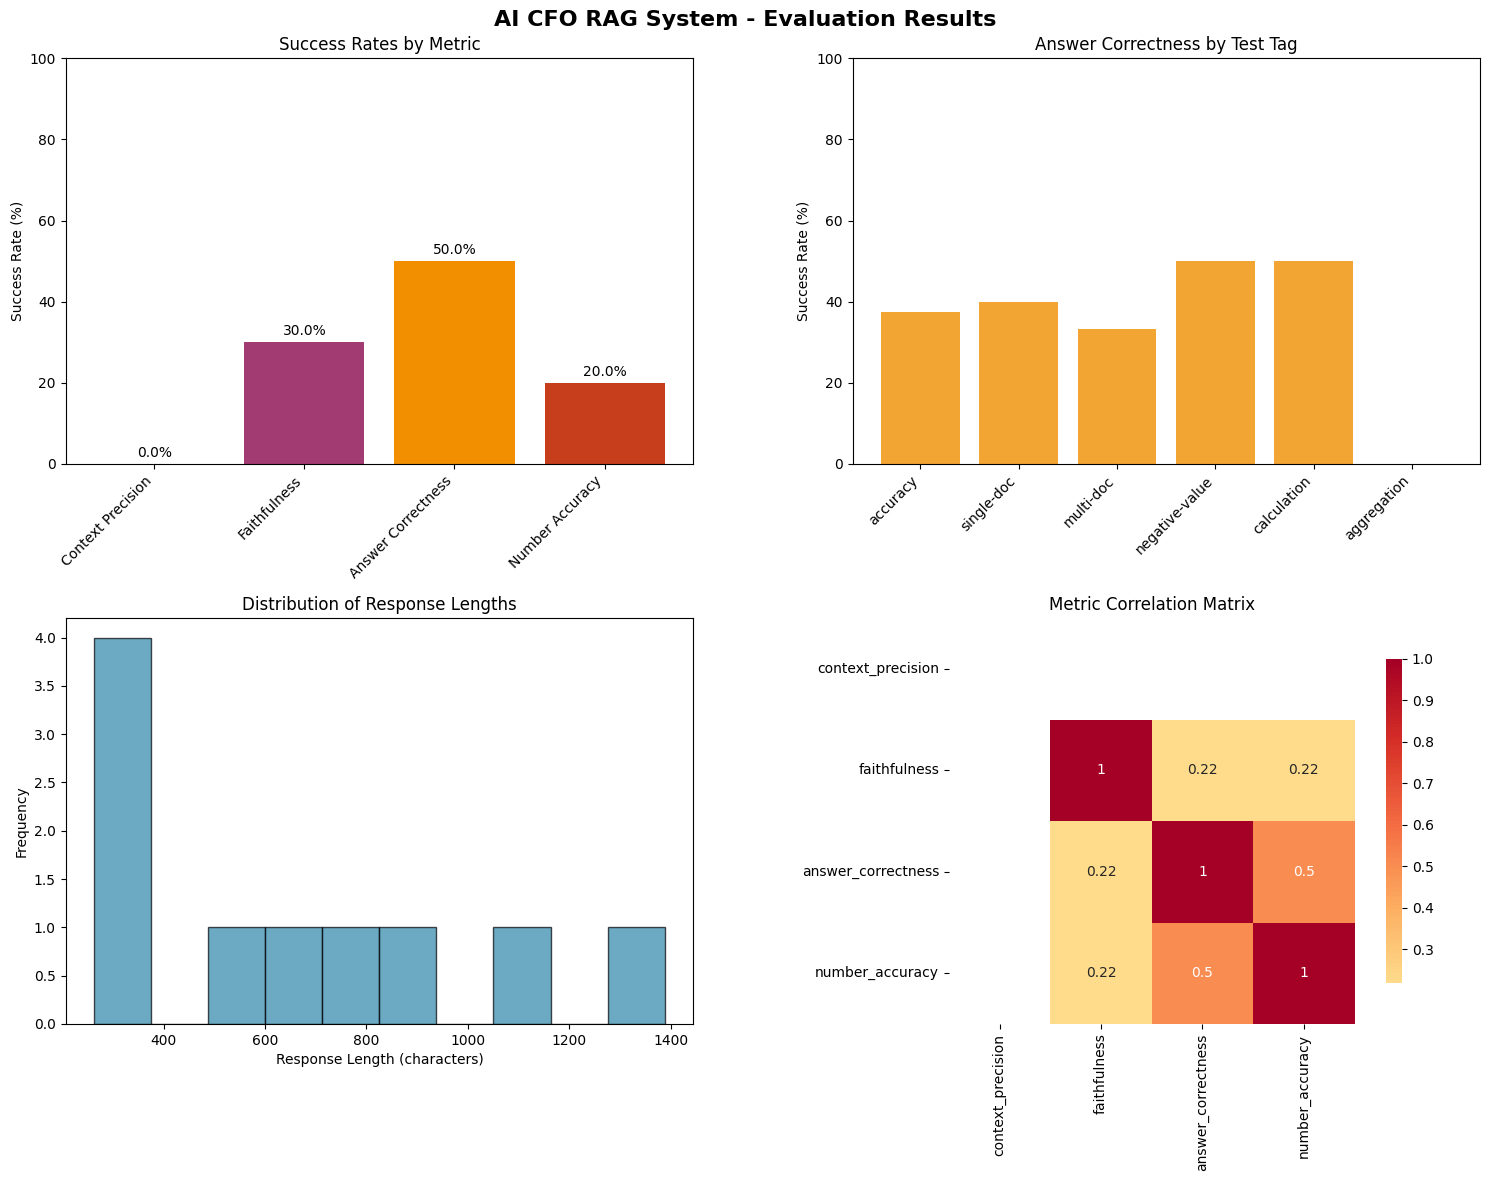


🎯 EVALUATION SUMMARY
📊 Overall System Performance: 25.0%
🏆 Best Performing Metric: Answer Correctness (50.0%)
⚠️ Needs Improvement: Context Precision (0.0%)

📋 Test Results:
  Total evaluations: 40
  Failed evaluations: 30
  Success rate: 25.0%

💾 Full results saved to: eval_results.csv

✅ Evaluation harness completed successfully!


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

def highlight_failures(val):
    """
    Style function to highlight failures in red.
    """
    if val in ['NO', 'ERROR', 'UNKNOWN']:
        return 'color: red; font-weight: bold'
    elif val == 'YES':
        return 'color: green; font-weight: bold'
    else:
        return 'color: black'

def create_results_summary(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create comprehensive summary statistics.
    """
    metrics = ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']
    
    summary = {
        'total_cases': len(df),
        'metrics': {}
    }
    
    for metric in metrics:
        value_counts = df[metric].value_counts()
        total = len(df)
        
        summary['metrics'][metric] = {
            'yes_count': value_counts.get('YES', 0),
            'no_count': value_counts.get('NO', 0),
            'error_count': value_counts.get('ERROR', 0),
            'unknown_count': value_counts.get('UNKNOWN', 0),
            'success_rate': (value_counts.get('YES', 0) / total) * 100,
            'failure_rate': (value_counts.get('NO', 0) / total) * 100,
            'error_rate': (value_counts.get('ERROR', 0) / total) * 100
        }
    
    return summary

def analyze_by_tags(df: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze performance by test case tags.
    """
    # Expand tags into separate rows
    tag_analysis = []
    
    for _, row in df.iterrows():
        for tag in row['tags']:
            tag_analysis.append({
                'tag': tag,
                'test_id': row['test_id'],
                'context_precision': row['context_precision'],
                'faithfulness': row['faithfulness'],
                'answer_correctness': row['answer_correctness'],
                'number_accuracy': row['number_accuracy']
            })
    
    tag_df = pd.DataFrame(tag_analysis)
    
    # Calculate success rates by tag
    tag_summary = []
    
    for tag in tag_df['tag'].unique():
        tag_data = tag_df[tag_df['tag'] == tag]
        
        summary_row = {'tag': tag, 'count': len(tag_data)}
        
        for metric in ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']:
            yes_count = (tag_data[metric] == 'YES').sum()
            success_rate = (yes_count / len(tag_data)) * 100
            summary_row[f'{metric}_success_rate'] = round(success_rate, 1)
        
        tag_summary.append(summary_row)
    
    return pd.DataFrame(tag_summary).sort_values('count', ascending=False)

# Display results overview
print("\n" + "="*60)
print("📊 EVALUATION RESULTS ANALYSIS")
print("="*60)

print(f"\n📈 Dataset Overview:")
print(f"Total test cases: {len(evaluation_results)}")
print(f"Average response length: {evaluation_results['response_length'].mean():.0f} characters")
print(f"Average context length: {evaluation_results['context_length'].mean():.0f} characters")

# Create and display styled results table
print("\n📋 Detailed Results (with failure highlighting):")
metrics_cols = ['context_precision', 'faithfulness', 'answer_correctness', 'number_accuracy']
display_cols = ['test_id', 'tags'] + metrics_cols + ['response_length']

styled_df = evaluation_results[display_cols].style.applymap(
    highlight_failures, 
    subset=metrics_cols
).format({
    'response_length': '{:.0f}'
})

display(styled_df)

# Generate summary statistics
summary = create_results_summary(evaluation_results)

print("\n📊 Summary Statistics:")
print("=" * 40)

for metric, stats in summary['metrics'].items():
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  ✅ Success: {stats['yes_count']}/{summary['total_cases']} ({stats['success_rate']:.1f}%)")
    print(f"  ❌ Failure: {stats['no_count']}/{summary['total_cases']} ({stats['failure_rate']:.1f}%)")
    if stats['error_count'] > 0:
        print(f"  🚨 Error: {stats['error_count']}/{summary['total_cases']} ({stats['error_rate']:.1f}%)")

# Analyze performance by tags
tag_analysis = analyze_by_tags(evaluation_results)

print("\n🏷️ Performance by Tag:")
print("=" * 40)
display(tag_analysis)

# Create visualizations
print("\n📈 Generating Visualizations...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('AI CFO RAG System - Evaluation Results', fontsize=16, fontweight='bold')

# 1. Overall Success Rates
ax1 = axes[0, 0]
metrics = ['Context Precision', 'Faithfulness', 'Answer Correctness', 'Number Accuracy']
success_rates = [summary['metrics'][m.lower().replace(' ', '_')]['success_rate'] for m in metrics]

bars1 = ax1.bar(metrics, success_rates, color=['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'])
ax1.set_title('Success Rates by Metric')
ax1.set_ylabel('Success Rate (%)')
ax1.set_ylim(0, 100)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, rate in zip(bars1, success_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{rate:.1f}%', ha='center', va='bottom')

# 2. Performance by Tag
ax2 = axes[0, 1]
tag_subset = tag_analysis.head(6)  # Top 6 most common tags
x_pos = range(len(tag_subset))

ax2.bar(x_pos, tag_subset['answer_correctness_success_rate'], 
        color='#F18F01', alpha=0.8, label='Answer Correctness')
ax2.set_title('Answer Correctness by Test Tag')
ax2.set_ylabel('Success Rate (%)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(tag_subset['tag'], rotation=45, ha='right')
ax2.set_ylim(0, 100)

# 3. Response Length Distribution
ax3 = axes[1, 0]
ax3.hist(evaluation_results['response_length'], bins=10, color='#2E86AB', alpha=0.7, edgecolor='black')
ax3.set_title('Distribution of Response Lengths')
ax3.set_xlabel('Response Length (characters)')
ax3.set_ylabel('Frequency')

# 4. Metric Correlation Heatmap
ax4 = axes[1, 1]

# Convert metrics to numeric for correlation
numeric_metrics = evaluation_results[metrics_cols].copy()
for col in metrics_cols:
    numeric_metrics[col] = numeric_metrics[col].map({'YES': 1, 'NO': 0, 'ERROR': -1, 'UNKNOWN': -1})

correlation_matrix = numeric_metrics.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0, 
            square=True, ax=ax4, cbar_kws={'shrink': 0.8})
ax4.set_title('Metric Correlation Matrix')

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*60)
print("🎯 EVALUATION SUMMARY")
print("="*60)

overall_success = sum(stats['success_rate'] for stats in summary['metrics'].values()) / len(summary['metrics'])
print(f"📊 Overall System Performance: {overall_success:.1f}%")

best_metric = max(summary['metrics'].items(), key=lambda x: x[1]['success_rate'])
worst_metric = min(summary['metrics'].items(), key=lambda x: x[1]['success_rate'])

print(f"🏆 Best Performing Metric: {best_metric[0].replace('_', ' ').title()} ({best_metric[1]['success_rate']:.1f}%)")
print(f"⚠️ Needs Improvement: {worst_metric[0].replace('_', ' ').title()} ({worst_metric[1]['success_rate']:.1f}%)")

# Count total failures
total_failures = sum(stats['no_count'] + stats['error_count'] for stats in summary['metrics'].values())
total_tests = len(summary['metrics']) * summary['total_cases']

print(f"\n📋 Test Results:")
print(f"  Total evaluations: {total_tests}")
print(f"  Failed evaluations: {total_failures}")
print(f"  Success rate: {((total_tests - total_failures) / total_tests) * 100:.1f}%")

print(f"\n💾 Full results saved to: {EVAL_RESULTS_PATH}")
print("\n✅ Evaluation harness completed successfully!")

## Conclusion

This evaluation harness provides a comprehensive framework for testing the AI CFO RAG system. The results help identify:

1. **System Reliability**: How consistently the system produces correct answers
2. **Context Quality**: Whether retrieved information is relevant to questions
3. **Faithfulness**: Whether answers stay grounded in the retrieved context
4. **Numerical Accuracy**: Critical for financial applications

### Next Steps

1. **Improve Context Capture**: Implement proper instrumentation to capture retrieved context from tool calls
2. **Expand Golden Dataset**: Add more test cases covering edge cases and complex scenarios
3. **Add Custom Metrics**: Implement domain-specific financial accuracy metrics
4. **Automated Monitoring**: Set up continuous evaluation with alerts for performance degradation
5. **A/B Testing**: Use this harness to compare different model configurations

### Key Features of This Harness

- ✅ **Modular Design**: Easy to extend with new metrics or test cases
- ✅ **Non-Intrusive**: Works with existing codebase without modifications
- ✅ **Comprehensive**: Covers multiple evaluation dimensions
- ✅ **Flexible**: Supports different judge models via LiteLLM
- ✅ **Visual**: Provides clear insights through charts and styling
- ✅ **Reproducible**: All results are saved for historical analysis